In [1]:
%pip install datasets

In [2]:
!sudo apt install aria2

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libaria2-0 libc-ares2
The following NEW packages will be installed:
  aria2 libaria2-0 libc-ares2
0 upgraded, 3 newly installed, 0 to remove and 35 not upgraded.
Need to get 1,513 kB of archives.
After this operation, 5,441 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libc-ares2 amd64 1.18.1-1ubuntu0.22.04.3 [45.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libaria2-0 amd64 1.36.0-1 [1,086 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 aria2 amd64 1.36.0-1 [381 kB]
Fetched 1,513 kB in 1s (1,319 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 3.)
debconf: falling back to front

In [ ]:
# !curl -L -o dataset.parquet "https://files.fileditch.st/b54/OgzSoFUTPJqwzYdyRqO.parquet?md5=j2vxeelF0XLfw4W-A1H0Gg&expires=1748462614"

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Salin file dari Google Drive ke direktori kerja Colab
import shutil
embedding_file_name = input("Embedding Files Name =   ")
# Path ke file sumber di Google Drive
source_path = f'/content/drive/My Drive/FP_NLP_EXPERIMENTS/2_EMBEDDING/{embedding_file_name}'

# Path tujuan di direktori kerja Colab
destination_path = '/content/dataset.parquet'

# Menyalin file
shutil.copy(source_path, destination_path)

print(f'File berhasil disalin ke {destination_path}')

Mounted at /content/drive
Embedding Files Name =   9900+Random.parquet
File berhasil disalin ke /content/dataset.parquet


In [4]:
!pip install datasets --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [5]:
import datasets

In [ ]:
ds = datasets.load_dataset("parquet", data_files="dataset.parquet")

In [7]:
ds["train"]["image"][0]

'coco/train2017/000000166124.jpg'

In [8]:
ds["train"]["conversations"][0]

[{'from': 'human',
  'value': 'Analisis gambar tersebut secara komprehensif dan terperinci. \n<image>'},
 {'from': 'gpt',
  'value': 'Gambar tersebut menangkap sebuah adegan yang menyenangkan dari seni kuliner - enam bagel yang baru dipanggang, kerak keemasan mereka mengkilap di bawah cahaya. Setiap bagel diberi taburan biji wijen secara murah hati, menambahkan sentuhan tekstur dan rasa pada penampilan mereka yang sudah menggugah selera. Mereka disusun dengan rapi di atas rak pendingin kawat, dalam dua baris tiga. Baris atas sedikit tumpang tindih dengan baris bawah, menciptakan dinamika visual yang menarik. Rak pendingin berada di atas meja kayu, dengan serat alaminya menambahkan pesona pedesaan pada adegan. Latar belakang kabur dan tidak jelas, memungkinkan perhatian penonton tetap pada kreasi lezat ini. Ini adalah gambar sederhana namun menawan yang berbicara banyak tentang seni memanggang. <image>'}]

In [9]:
import pandas as pd

In [10]:
!pip install einops

In [11]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import get_linear_schedule_with_warmup
from transformers import AutoTokenizer
import wandb
from tqdm import tqdm
from torch import nn
from einops import rearrange
from transformers import AutoModelForCausalLM, AutoTokenizer

In [12]:
import torch
from torch import nn
from einops import rearrange
from transformers import AutoModelForCausalLM, AutoTokenizer

class VisionProjection(nn.Module):
    def __init__(self, vision_dim, llama_dim):
        super().__init__()
        hidden_dim = llama_dim * 4

        self.mlp = MLP(vision_dim, hidden_dim, llama_dim)

        torch.nn.init.kaiming_normal_(self.mlp.fc1.weight, mode="fan_in", nonlinearity="relu")
        torch.nn.init.kaiming_normal_(self.mlp.fc2.weight, mode="fan_in", nonlinearity="relu")

    def forward(self, x):
        # Squeeze out the unnecessary second dimension if it exists and is of size 1
        if x.dim() == 5 and x.shape[1] == 1:
            x = x.squeeze(1) # This removes the dimension at index 1

        # Now x should have the shape (b, c, h, w)
        x = rearrange(x, 'b c h w -> b (h w) c')
        return self.mlp(x)

class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

class MultimodalLlama(nn.Module):
    def __init__(self, vision_dim=512, llama_dim=2048):
        super().__init__()

        # Vision components
        self.vision_projection = VisionProjection(vision_dim, llama_dim)

        # Load Llama model
        self.llama = AutoModelForCausalLM.from_pretrained("alpindale/Llama-3.2-1B-Instruct")
        self.tokenizer = AutoTokenizer.from_pretrained("alpindale/Llama-3.2-1B-Instruct")

        # Add special tokens
        special_tokens = {'additional_special_tokens': ['<image>', '</image>']}
        self.tokenizer.add_special_tokens(special_tokens)

        # Store image token ID
        self.image_token_id = self.tokenizer.convert_tokens_to_ids("<image>")

    def encode_image(self, image_features):
        # Project ResNet features to Llama dimension
        return self.vision_projection(image_features)

    def forward(self, input_ids, image_features=None, attention_mask=None, labels=None):
        if image_features is not None:
            with torch.no_grad():
                inputs_embeds = self.llama.get_input_embeddings()(input_ids).detach()

            inputs_embeds = inputs_embeds.clone().detach().requires_grad_(True)
            image_embeds = self.encode_image(image_features)

            # print("inputs_embeds shape:", inputs_embeds.shape)
            # print("image_embeds shape:", image_embeds.shape)

            image_token_pos = torch.where(input_ids == self.image_token_id)

            if len(image_token_pos[0]) > 0:
                pos = image_token_pos[1][0]

                # Concatenate embeddings
                inputs_embeds = torch.cat([
                    inputs_embeds[:,:pos],
                    image_embeds,
                    inputs_embeds[:,pos+1:]
                ], dim=1)

                # Update attention mask
                if attention_mask is not None:
                    attention_mask = torch.cat([
                        attention_mask[:,:pos],
                        torch.ones((attention_mask.shape[0], image_embeds.shape[1]), device=attention_mask.device),
                        attention_mask[:,pos+1:]
                    ], dim=1)

                # Update labels to match new sequence length
                if labels is not None:
                    labels = torch.cat([
                        labels[:,:pos],
                        torch.full((labels.shape[0], image_embeds.shape[1]), -100, device=labels.device),  # Fill with ignore_index
                        labels[:,pos+1:]
                    ], dim=1)

            return self.llama(
                inputs_embeds=inputs_embeds,
                attention_mask=attention_mask,
                labels=labels
            )
        else:
            return self.llama(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )


    def generate(self, input_ids, image_features=None, **kwargs):
        if image_features is not None:
            inputs_embeds = self.llama.get_input_embeddings()(input_ids)
            image_embeds = self.encode_image(image_features)

            # Insert image embeddings
            image_token_pos = (input_ids == self.tokenizer.convert_tokens_to_ids("<image>")).nonzero()
            if len(image_token_pos) > 0:
                pos = image_token_pos[0,1]
                inputs_embeds = torch.cat([
                    inputs_embeds[:,:pos],
                    image_embeds.unsqueeze(1),
                    inputs_embeds[:,pos+1:]
                ], dim=1)

            return self.llama.generate(inputs_embeds=inputs_embeds, **kwargs)
        else:
            return self.llama.generate(input_ids=input_ids, **kwargs)

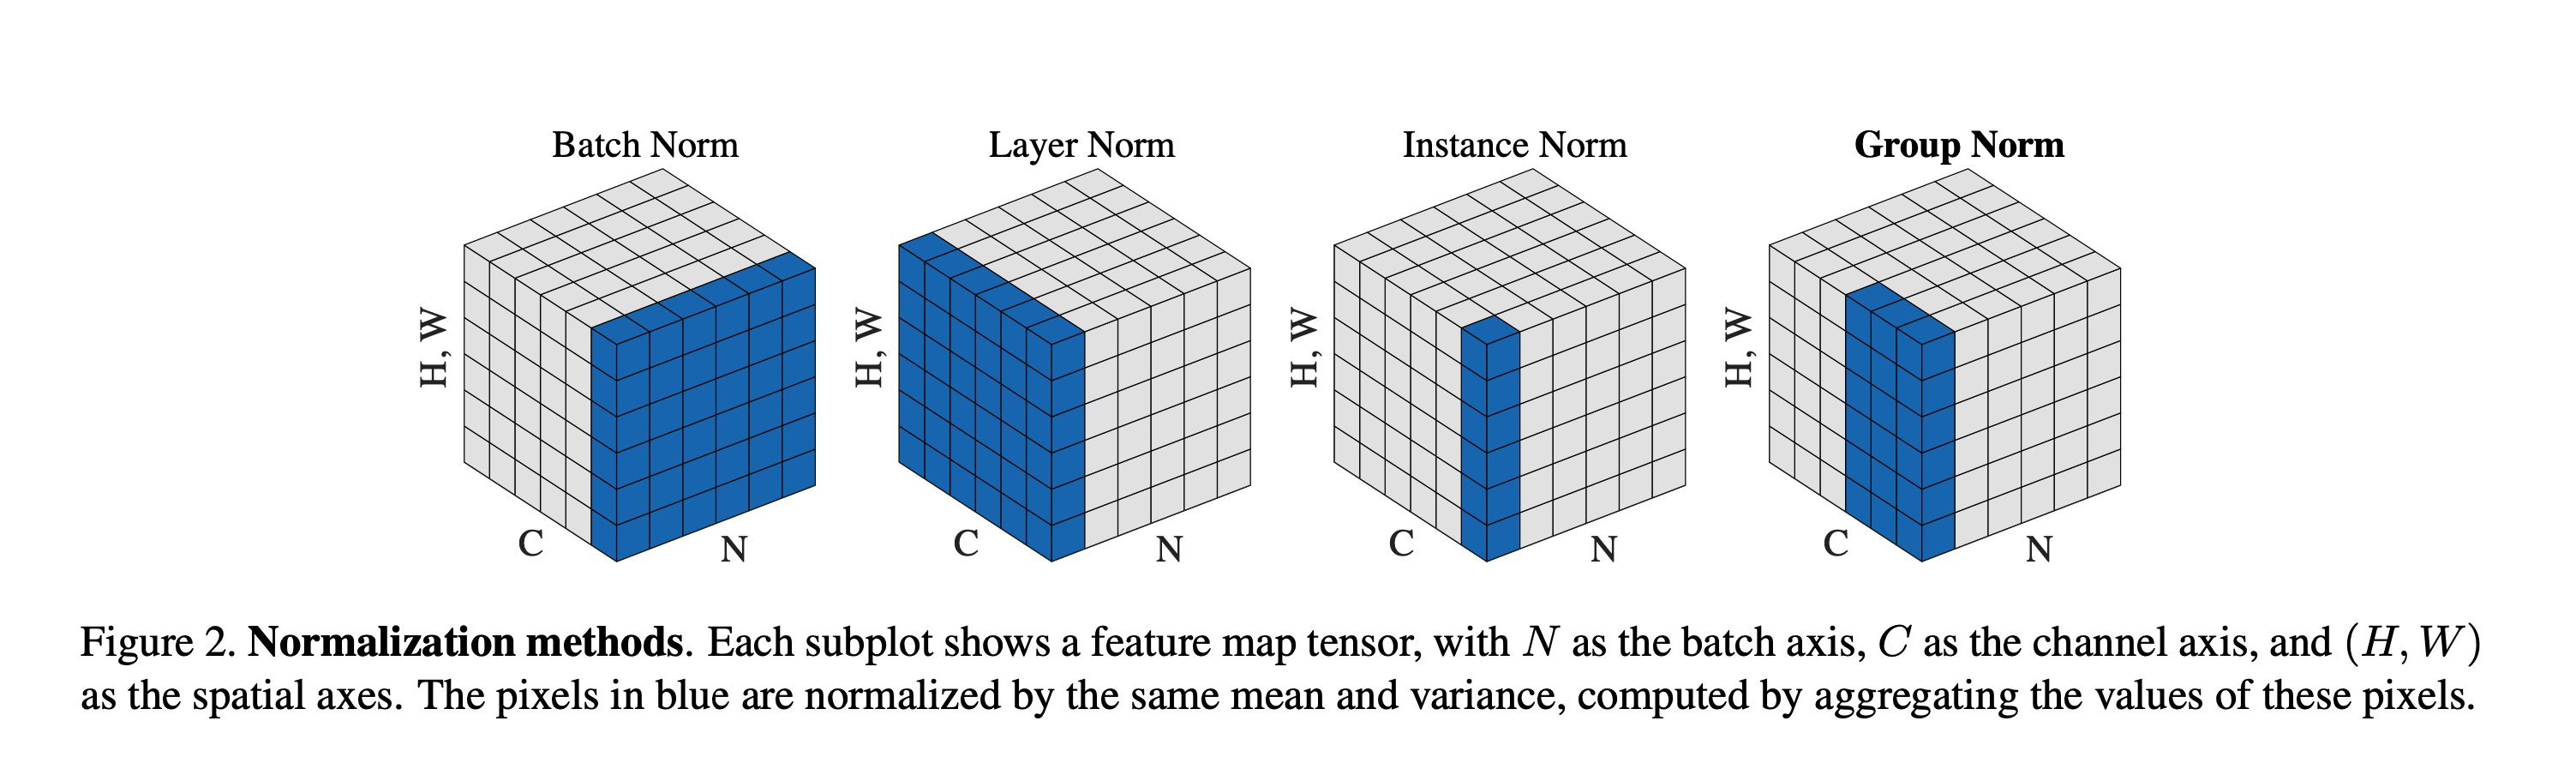

In [13]:
import datetime
dt = datetime.datetime.now()

In [14]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import get_cosine_schedule_with_warmup
from transformers import AutoTokenizer
from google.colab import userdata
import wandb
from tqdm import tqdm
import datetime
import os
import shutil
import random
import numpy as np

wandb.login(key=userdata.get('WANDB_KEY'))

# Set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Custom dataset class
class MultimodalDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_length=512):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        # Get conversation and format it
        conversation = item['conversations']
        prompt = conversation[0]['value']  # Human prompt with <image>
        response = conversation[1]['value']  # GPT response

        # Combine prompt and response
        full_text = self.tokenizer.apply_chat_template(
            [
                {"role": "user", "content": prompt},
                {"role": "assistant", "content": response}
            ],
            add_generation_prompt=True,
            tokenize=False,
        )

        # Tokenize
        encodings = self.tokenizer(
            full_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Get image embeddings
        image_embeddings = torch.tensor(item['embedding'])

        return {
            'input_ids': encodings['input_ids'].squeeze(),
            'attention_mask': encodings['attention_mask'].squeeze(),
            'image_embeddings': image_embeddings,
            'labels': encodings['input_ids'].squeeze()  # Use same tokens for labels
        }
# Save checkpoint function
def save_checkpoint(model, optimizer, scheduler, epoch, loss, filepath, config):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': loss,
        'config': config,
        'torch_rng_state': torch.get_rng_state(),
        'numpy_rng_state': np.random.get_state(),
        'random_rng_state': random.getstate(),
    }
    if torch.cuda.is_available():
        checkpoint['cuda_rng_state'] = torch.cuda.get_rng_state()

    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved at {filepath}")

# Load checkpoint function
def load_checkpoint(filepath, model, optimizer=None, scheduler=None):
    checkpoint = torch.load(filepath, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])

    # Restore random states
    torch.set_rng_state(checkpoint['torch_rng_state'])
    np.random.set_state(checkpoint['numpy_rng_state'])
    random.setstate(checkpoint['random_rng_state'])
    if torch.cuda.is_available() and 'cuda_rng_state' in checkpoint:
        torch.cuda.set_rng_state(checkpoint['cuda_rng_state'])

    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    if scheduler is not None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

    return checkpoint['epoch'], checkpoint['loss'], checkpoint['config']

# Modified training function
def train_model(model, train_dataset, val_dataset, config, resume_from_checkpoint=None):
    """
    Training loop for MultimodalLlama with checkpoint support
    """
    dt = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

    # Create checkpoint directory
    checkpoint_dir = f'/content/drive/My Drive/FP_NLP_EXPERIMENTS/3_TRAINING_MODELS/{dt}'
    os.makedirs(checkpoint_dir, exist_ok=True)

    # Initialize wandb
    wandb.init(
        project="multimodal-llama",
        config=config,
        resume="allow" if resume_from_checkpoint else None
    )

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config['batch_size'],
        shuffle=True,
        num_workers=config['num_workers']
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=config['batch_size'],
        shuffle=False,
        num_workers=config['num_workers']
    )

    # Setup optimizer and scheduler
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config['learning_rate'],
        weight_decay=config['weight_decay']
    )

    num_training_steps = len(train_loader) * config['num_epochs']
    num_warmup_steps = int(num_training_steps * config['warmup_ratio'])

    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=num_warmup_steps,
        num_training_steps=num_training_steps
    )

    # Move model to device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Resume from checkpoint if provided
    start_epoch = 0
    best_val_loss = float('inf')

    if resume_from_checkpoint:
        print(f"Resuming from checkpoint: {resume_from_checkpoint}")
        start_epoch, best_val_loss, loaded_config = load_checkpoint(
            resume_from_checkpoint, model, optimizer, scheduler
        )
        start_epoch += 1  # Start from next epoch
        print(f"Resumed from epoch {start_epoch}, best val loss: {best_val_loss}")

    # Training loop
    for epoch in range(start_epoch, config['num_epochs']):
        model.train()
        total_train_loss = 0

        # Training
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{config["num_epochs"]} [Train]')
        for batch_idx, batch in enumerate(train_pbar):
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}

            # Clear gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(
                input_ids=batch['input_ids'],
                image_features=batch['image_embeddings'],
                attention_mask=batch['attention_mask'],
                labels=batch['labels']
            )

            loss = outputs.loss
            total_train_loss += loss.item()

            # Backward pass
            loss.backward()

            # Clip gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), config['max_grad_norm'])

            # Update weights
            optimizer.step()
            scheduler.step()

            # Update progress bar
            train_pbar.set_postfix({'loss': loss.item()})

            # Log to wandb
            wandb.log({
                'train_batch_loss': loss.item(),
                'learning_rate': scheduler.get_last_lr()[0],
                'epoch': epoch,
                'batch': batch_idx
            })

        avg_train_loss = total_train_loss / len(train_loader)

        # Validation
        model.eval()
        total_val_loss = 0

        val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{config["num_epochs"]} [Val]')
        with torch.no_grad():
            for batch in val_pbar:
                batch = {k: v.to(device) for k, v in batch.items()}

                outputs = model(
                    input_ids=batch['input_ids'],
                    image_features=batch['image_embeddings'],
                    attention_mask=batch['attention_mask'],
                    labels=batch['labels']
                )

                loss = outputs.loss
                total_val_loss += loss.item()

                val_pbar.set_postfix({'loss': loss.item()})

        avg_val_loss = total_val_loss / len(val_loader)

        # Log epoch metrics
        wandb.log({
            'train_epoch_loss': avg_train_loss,
            'val_epoch_loss': avg_val_loss,
            'epoch': epoch
        })

        # Save checkpoint after each epoch
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch}.pt')
        save_checkpoint(model, optimizer, scheduler, epoch, avg_val_loss, checkpoint_path, config)

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_path = os.path.join(checkpoint_dir, f'best_model_epoch_{epoch}.pt')
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model saved at epoch {epoch}")

        print(f'Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}')

        # Early stopping condition for phase 1 (epochs 1-3)
        if config.get('phase') == 1 and epoch >= 2:  # 0-indexed, so 2 = epoch 3
            print(f"Phase 1 complete. Stopping at epoch {epoch+1}")
            break

    wandb.finish()
    return model




wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: abdan-hafidz (abdan-hafidz-institut-teknologi-sepuluh-nopember) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
# Training configuration
config = {
    'batch_size': 8,
    'num_workers': 11,
    'learning_rate': 2e-5,
    'weight_decay': 0.01,
    'num_epochs': 6,
    'warmup_ratio': 0.1,
    'max_grad_norm': 1.0,
    'max_length': 512,
    'phase': 1,  # 1 for epochs 1-3, 2 for epochs 4-6
    'seed': 42
}

# Usage example:
def main():
    # Set seed for reproducibility
    set_seed(config['seed'])

    # Initialize tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained("alpindale/Llama-3.2-1B-Instruct")

    # Set pad token to eos token if it doesn't exist
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "right"

    # Add special tokens
    special_tokens = {'additional_special_tokens': ['<image>', '</image>']}
    num_added_tokens = tokenizer.add_special_tokens(special_tokens)

    # Print to verify the token was added
    print("Image token ID:", tokenizer.convert_tokens_to_ids("<image>"))

    # Initialize model
    model = MultimodalLlama()

    # Resize token embeddings to account for new special tokens
    model.llama.resize_token_embeddings(len(tokenizer))

    model.llama.eval()

    for param in model.llama.parameters():
        param.requires_grad = False

    # Only projection layer parameters should be trainable
    for param in model.vision_projection.parameters():
        param.requires_grad = True

    # Prepare datasets
    split_datasets = ds['train'].train_test_split(
        test_size=0.1,
        seed=42
    )

    train_dataset = MultimodalDataset(split_datasets['train'], tokenizer)
    val_dataset = MultimodalDataset(split_datasets['test'], tokenizer)

    # PHASE 1: Train epochs 1-3
    print("Starting Phase 1: Epochs 1-3")
    config['phase'] = 1
    config['num_epochs'] = 3

    trained_model = train_model(model, train_dataset, val_dataset, config)

    print("Phase 1 complete! Use the generated checkpoint to continue Phase 2.")

# Function to resume training (for Phase 2)
def resume_training(checkpoint_path):
    # Set seed for reproducibility
    set_seed(config['seed'])

    # Initialize tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained("alpindale/Llama-3.2-1B-Instruct")

    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "right"

    special_tokens = {'additional_special_tokens': ['<image>', '</image>']}
    num_added_tokens = tokenizer.add_special_tokens(special_tokens)

    model = MultimodalLlama()
    model.llama.resize_token_embeddings(len(tokenizer))

    model.llama.eval()
    for param in model.llama.parameters():
        param.requires_grad = False
    for param in model.vision_projection.parameters():
        param.requires_grad = True

    # Prepare datasets
    split_datasets = ds['train'].train_test_split(
        test_size=0.1,
        seed=42
    )

    train_dataset = MultimodalDataset(split_datasets['train'], tokenizer)
    val_dataset = MultimodalDataset(split_datasets['test'], tokenizer)

    # PHASE 2: Train epochs 4-6
    print("Starting Phase 2: Epochs 4-6")
    config['phase'] = 2
    config['num_epochs'] = 6

    trained_model = train_model(
        model,
        train_dataset,
        val_dataset,
        config,
        resume_from_checkpoint=checkpoint_path
    )

    # Save final model
    torch.save(trained_model.state_dict(), 'final_model.pt')
    print("Training complete!")


In [ ]:

if __name__ == "__main__":
    main()

    # For tomorrow (Phase 2) - uncomment and use the checkpoint path
    # checkpoint_path = "/path/to/your/checkpoint_epoch_2.pt"
    # resume_training(checkpoint_path)

Image token ID: 128256
Starting Phase 1: Epochs 1-3


batch,▁▁▁▃▃▄▄▄▄▅▅▆▆▇▂▃▃▃▄▄▅▅▅▅▅▅▆▆▆▇▇▇█▁▂▂▂▃▃▃
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅███
learning_rate,▁▁▃▃▇█████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂
train_batch_loss,█▃▃▂▂▄▁▃▂▄▂▃▂▃▂▂▂▂▂▂▂▂▃▃▂▃▂▂▃▂▂▃▂▃▂▁▂▂▂▃
train_epoch_loss,█▁
val_epoch_loss,█▁
batch,472
epoch,2
learning_rate,0.0
train_batch_loss,1.79432
train_epoch_loss,1.78459


Epoch 1/3 [Train]:   0%|          | 0/1125 [00:02<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.14 GiB. GPU 0 has a total capacity of 39.56 GiB of which 328.88 MiB is free. Process 26303 has 39.23 GiB memory in use. Of the allocated memory 38.64 GiB is allocated by PyTorch, and 96.68 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
checkpoint_path = "/content/drive/My Drive/FP_NLP_EXPERIMENTS/3_TRAINING_MODELS/20250617_161811/checkpoint_epoch_1.pt"
resume_training(checkpoint_path)

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Starting Phase 2: Epochs 4-6


Resuming from checkpoint: /content/drive/My Drive/FP_NLP_EXPERIMENTS/3_TRAINING_MODELS/20250617_161811/checkpoint_epoch_1.pt
Resumed from epoch 2, best val loss: 1.7609914827346802


Epoch 3/6 [Val]: 100%|██████████| 125/125 [01:24<00:00,  1.47it/s, loss=1.64]


Checkpoint saved at /content/drive/My Drive/FP_NLP_EXPERIMENTS/3_TRAINING_MODELS/20250617_172742/checkpoint_epoch_2.pt
New best model saved at epoch 2
Epoch 3: Train Loss = 1.7576, Val Loss = 1.7464


Epoch 4/6 [Val]: 100%|██████████| 125/125 [01:24<00:00,  1.48it/s, loss=1.63]


Checkpoint saved at /content/drive/My Drive/FP_NLP_EXPERIMENTS/3_TRAINING_MODELS/20250617_172742/checkpoint_epoch_3.pt
New best model saved at epoch 3
Epoch 4: Train Loss = 1.7407, Val Loss = 1.7345


Epoch 5/6 [Val]: 100%|██████████| 125/125 [01:24<00:00,  1.48it/s, loss=1.63]


Checkpoint saved at /content/drive/My Drive/FP_NLP_EXPERIMENTS/3_TRAINING_MODELS/20250617_172742/checkpoint_epoch_4.pt
New best model saved at epoch 4
Epoch 5: Train Loss = 1.7260, Val Loss = 1.7300


Epoch 6/6 [Val]: 100%|██████████| 125/125 [01:24<00:00,  1.48it/s, loss=1.63]


Checkpoint saved at /content/drive/My Drive/FP_NLP_EXPERIMENTS/3_TRAINING_MODELS/20250617_172742/checkpoint_epoch_5.pt
New best model saved at epoch 5
Epoch 6: Train Loss = 1.7281, Val Loss = 1.7290


batch,▂▃▄▄▅▆▇██▂▃▄▄▅▅▆▆▂▂▂▄▄▄▄▅▅▅▆█▁▂▂▃▃▃▄▄▅▅▇
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆██████
learning_rate,█████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
train_batch_loss,▄▄▅█▇▄▃▆▅▅▄▅▅▄▆█▄▇▆▅▄▃▁▃▅▆▃▄▅▄▅▄▂▆▆▅▅▇▄▇
train_epoch_loss,█▄▁▁
val_epoch_loss,█▃▁▁
batch,1124
epoch,5
learning_rate,0
train_batch_loss,1.26838
train_epoch_loss,1.7281


Training complete!


In [15]:
import shutil
embedding_file_name = input("Models Path =   ")
# Path ke file sumber di Google Drive
source_path = f'/content/drive/My Drive/FP_NLP_EXPERIMENTS/3_TRAINING_MODELS/{embedding_file_name}'

# Path tujuan di direktori kerja Colab
destination_path = '/content/base_model.pt'

# Menyalin file
shutil.copy(source_path, destination_path)

print(f'File berhasil disalin ke {destination_path}')

Models Path =   20250617_172742/best_model_epoch_5.pt
File berhasil disalin ke /content/base_model.pt


In [16]:
def fine_tuning():
    config = {
        'batch_size': 3,
        'num_workers': 11,
        'learning_rate': 2e-5,
        'weight_decay': 0.01,
        'num_epochs': 6,
        'warmup_ratio': 0.1,
        'max_grad_norm': 1.0,
        'max_length': 512,
        'phase': 1,  # 1 for epochs 1-3, 2 for epochs 4-6
        'seed': 42
    }
    # Set seed for reproducibility
    set_seed(config['seed'])

    # Initialize tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained("alpindale/Llama-3.2-1B-Instruct")

    # Set pad token to eos token if it doesn't exist
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "right"

    # Add special tokens
    special_tokens = {'additional_special_tokens': ['<image>', '</image>']}
    num_added_tokens = tokenizer.add_special_tokens(special_tokens)

    # Print to verify the token was added
    print("Image token ID:", tokenizer.convert_tokens_to_ids("<image>"))

    # Initialize model
    model = MultimodalLlama()

    # Resize token embeddings to account for new special tokens
    model.llama.resize_token_embeddings(len(tokenizer))
    model.load_state_dict(torch.load('/content/base_model.pt'))
    model.llama.eval()

    for param in model.llama.parameters():
        param.requires_grad = True

    # Only projection layer parameters should be trainable
    for param in model.vision_projection.parameters():
        param.requires_grad = True

    # Prepare datasets
    split_datasets = ds['train'].train_test_split(
        test_size=0.1,
        seed=42
    )

    train_dataset = MultimodalDataset(split_datasets['train'], tokenizer)
    val_dataset = MultimodalDataset(split_datasets['test'], tokenizer)

    # PHASE 1: Train epochs 1-3
    print("Starting Phase 1: Epochs 1-3")
    config['phase'] = 1
    config['num_epochs'] = 3

    trained_model = train_model(model, train_dataset, val_dataset, config)

    print("Phase 1 complete! Use the generated checkpoint to continue Phase 2.")

In [ ]:
fine_tuning()

In [18]:
from google.colab import drive
drive.flush_and_unmount()

In [19]:
from google.colab import runtime
runtime.unassign()